In [ ]:
!pip install split-folders

In [ ]:
!git clone https://github.com/karolzak/keras-unet.git

In [ ]:
!gdown 1jaZ2vRduPNfHTayKBK7WmvQ88DKZwPTw

In [ ]:
!unzip /content/png_png_512resize_multi_data_220727.zip

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.losses as losses
from glob import glob

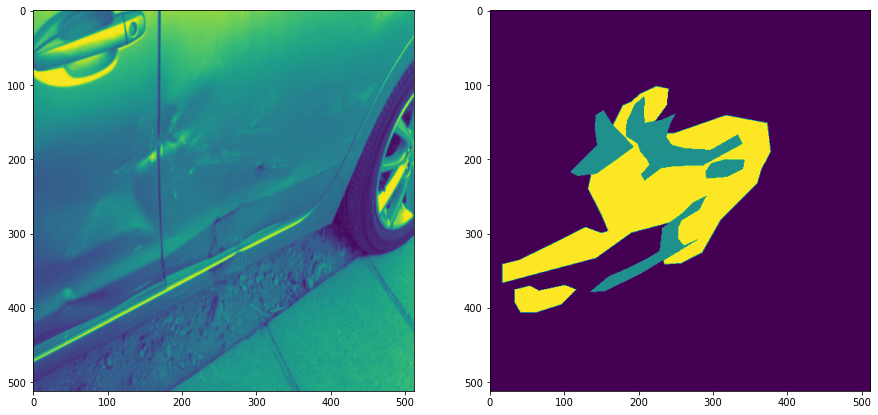

In [6]:
images_files = glob('/content/multi_mask_data3/images/*.png')
images_path = images_files[10]
seg_path = images_path.replace('images', 'masks')

image = cv2.imread(images_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(mask * 40)
plt.show()

In [7]:
mask = np.where(mask > 0, 1, 0)

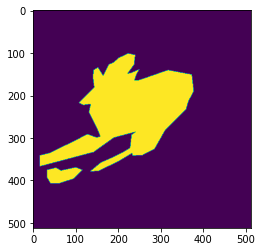

In [8]:
plt.imshow(mask)

In [9]:
def iou(y_true, y_pred):
    smooth = 1.
    y_true = tf.reshape(y_true, [-1]) # 2차원 이미지를 1차원으로 reshape
    y_pred = tf.reshape(y_pred, [-1]) # 2차원 이미지를 1차원으로 reshape

    intersection = tf.reduce_sum(y_true * y_pred) 
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    score  = intersection / (union + smooth)

    return score

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true = tf.reshape(y_true, [-1]) # 2차원 이미지를 1차원으로 reshape
    y_pred = tf.reshape(y_pred, [-1]) # 2차원 이미지를 1차원으로 reshape

    intersection = tf.reduce_sum(y_true * y_pred) 
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)

    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    return loss

In [10]:
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from tensorflow import keras

In [11]:
import splitfolders
splitfolders.ratio ('/content/multi_mask_data3', output = '/content/dataset', seed = 777, ratio = (0.8,0.1,0.1)) 

Copying files: 762 files [00:00, 2135.04 files/s]


In [12]:
train_path_list = glob('/content/dataset/train/images/*.png')
valid_path_list = glob('/content/dataset/val/images/*.png')

img_path: /content/dataset/train/images/d_0308.png
mask_path: /content/dataset/train/masks/d_0308.png


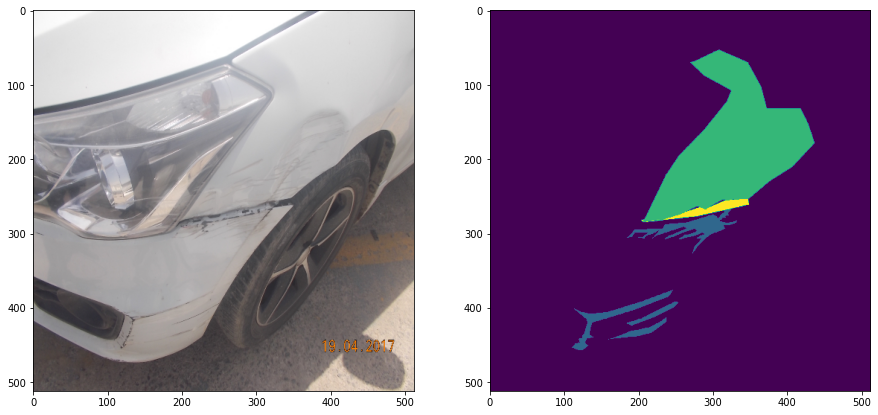

In [13]:
# csv_path = 'path'
# df = pd.read_csv(csv_path)
idx = random.choice(range(len(train_path_list)))

# file_name = df.loc[idx].file_name
img_path = train_path_list[idx]
mask_path = train_path_list[idx].replace('images', 'masks')

print('img_path:', img_path)
print('mask_path:', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

assert img.shape[:2] == mask.shape[:2]  ###  assert : 가정설정문 https://blockdmask.tistory.com/553

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask)
plt.show()

In [14]:
import albumentations as A
import cv2 

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
          
    def __call__(self, **kwags):
        if self.transform:
            augmented =self.transform(**kwags)
            img = augmented['image']
            mask = augmented['mask']
            
            return img, mask

In [15]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, path_list, image_size, mode='train', shuffle=True):
        # self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size

        self.path_list = path_list

        self.on_epoch_end()

        def __len__(self):
            return math.ceil(len(self.path) / self.batch_size)

        def __getitem__(self, idx):
            strt = idx * self.batch_size
            fin = (idx + 1) * self.batch_size
            data = self.path[strt:fin]

            batch_x, batch_y = self.get_data(data)

            return np.array(batch_x), np.array(batch_y)

        def get_data(self, data):
            batch_x = []
            batch_y = []

            for path in path_list:
                # file_name = r['file_name']
                image_path = path
                mask_path = path.replace('images', 'masks')
                
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                image = cv2.resize(image, (self.image_size, self.image_size))

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (self.image_size, self.image_size))
                mask[mask != 1] = 0

                if self.mode == 'train':
                    image = image.astype('uint8')
                    image, mask = self.transform(image=image, mask=mask)

                image = image.astype('float32')
                image = image / 255.

                batch_x.append(image)
                batch_y.append(mask)

            return batch_x, batch_y

        def on_epoch_end(self):
            if self.shuffle:
                self.path = self.path.sample(frac=1).reset_index(drop=True)


In [16]:
train_generator = DataGenerator(
    mode='train',
    path_list=train_path_list,
    batch_size=128,
    image_size=512,
    shuffle=True
)

valid_generator = DataGenerator(
    mode='val',
    path_list=valid_path_list,
    batch_size=128,
    image_size=512,
    shuffle=True
)

In [22]:
iter(train_generator)

<generator object Sequence.__iter__ at 0x7f4641feec50>

In [ ]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15,15))

    for i in range(3):
        plt.subplot(3, 2, i*2 + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.subplot(3, 2, i*2 + 2)
        plt.imshow(y[i], cmap='gray')
        plt.axis('off')
        plt.tight_layout()

In [ ]:
|cd /content/keras-unet

/content/keras-unet


In [ ]:
from keras_unet.models import custom_unet

In [ ]:
help(custom_unet)

In [ ]:
model = custom_unet(
    input_shape=(512, 512, 3),
    use_batch_norm=True, ### use Batch Normalisation // 일반적으로 쓰는게 좋음
    upsample_mode='deconv',
    dropout_type='spatial',
    use_attention=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 512, 512, 64  1728        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_69[0][0]']              
 ormalization)                  )                                                           

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

In [ ]:
import matplotlib.pyplot as plt

history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(122)
plt.plot(history['iou'], label='train')
plt.plot(history['val_iou'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('IoU')
plt.show()

In [ ]:
for images, masks in valid_generator:
    break

In [ ]:
preds = model.predict(images)

In [ ]:
import random

idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(images[idx, ...])
plt.subplot(122)
plt.imshow(preds[idx, ..., 0], cmap='gray')